In [60]:
import os, sys
from obspy.core import read, Stream
from obspy.io.xseed.core import _read_resp
from obspy.signal.freqattributes import spectrum
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
sys.path.append('/Users/thompsong/src/volcanoObsPy/LIB')
from libseisGT import eventStatistics


## imports for copying obspy spectrograms
from obspy.imaging.spectrogram import _nearest_pow_2
from matplotlib import mlab

# colormaps
# https://docs.obspy.org/packages/autogen/obspy.imaging.cm.html
# obspy_sequential is same as viridis, which is default for matplotlib
from obspy.imaging.cm import viridis_white_r, obspy_divergent, pqlx, obspy_sequential

# adding colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [72]:
def compute_spectrogram(data, samp_rate, per_lap=0.9, wlen=None, dbscale=False, mult=8.0):
    """
    Computes spectrogram of the input data.
    Modified from obspy.imaging.spectrogram because we want the plotting part of that method in a different function to this.

    :param data: Input data
    :type samp_rate: float
    :param samp_rate: Samplerate in Hz
    :type per_lap: float
    :param per_lap: Percentage of overlap of sliding window, ranging from 0
        to 1. High overlaps take a long time to compute.
    :type wlen: int or float
    :param wlen: Window length for fft in seconds. If this parameter is too
        small, the calculation will take forever. If None, it defaults to
        (samp_rate/100.0).
    :type dbscale: bool
    :param dbscale: If True 10 * log10 of color values is taken, if False the
        sqrt is taken.
    :type mult: float
    :param mult: Pad zeros to length mult * wlen. This will make the
        spectrogram smoother.

    """
    import matplotlib.pyplot as plt
    # enforce float for samp_rate
    samp_rate = float(samp_rate)

    # set wlen from samp_rate if not specified otherwise
    if not wlen:
        wlen = samp_rate / 100.

    npts = len(data)
    # nfft needs to be an integer, otherwise a deprecation will be raised
    # XXX add condition for too many windows => calculation takes for ever
    nfft = int(_nearest_pow_2(wlen * samp_rate))
    if nfft > npts:
        nfft = int(_nearest_pow_2(npts / 8.0))

    if mult is not None:
        mult = int(_nearest_pow_2(mult))
        mult = mult * nfft
    nlap = int(nfft * float(per_lap))

    data = data - data.mean()
    end = npts / samp_rate

    # Here we call not plt.specgram as this already produces a plot
    # matplotlib.mlab.specgram should be faster as it computes only the
    # arrays
    # XXX mlab.specgram uses fft, would be better and faster use rfft
    specgram, freq, time = mlab.specgram(data, Fs=samp_rate, NFFT=nfft,
                                         pad_to=mult, noverlap=nlap)
    # db scale and remove zero/offset for amplitude
    if dbscale:
        specgram = 10 * np.log10(specgram[1:, :])
    else:
        specgram = np.sqrt(specgram[1:, :])
        
    return time, freq, specgram
        
        

def plot_single_spectrogram(time, freq, specgram, log=False,
                outfile=None, fmt=None, axes=None,
                cmap=obspy_sequential, zorder=None, title=None,
                show=True, sphinx=False, clip=[0.0, 1.0]):
    """
    Plot spectrogram computed by compute_spectrogram.
    Modified from obspy.imaging.spectrogram because we wanted to split the computation and plotting into different functions
    
    :type time: numpy array of float
    :param time: Time vector (1xN)
    :type freq: numpy array of float
    :param freq: Frequency vector (1xM)
    :type specgram: numpy 2-D array of float
    :param specgram: Amplitude array (NxM)    
    :type log: bool
    :param log: Logarithmic frequency axis if True, linear frequency axis
        otherwise.
    :type outfile: str
    :param outfile: String for the filename of output file, if None
        interactive plotting is activated.
    :type fmt: str
    :param fmt: Format of image to save
    :type axes: :class:`matplotlib.axes.Axes`
    :param axes: Plot into given axes, this deactivates the fmt and
        outfile option.
    :type cmap: :class:`matplotlib.colors.Colormap`
    :param cmap: Specify a custom colormap instance. If not specified, then the
        default ObsPy sequential colormap is used.
    :type zorder: float
    :param zorder: Specify the zorder of the plot. Only of importance if other
        plots in the same axes are executed.
    :type title: str
    :param title: Set the plot title
    :type show: bool
    :param show: Do not call `plt.show()` at end of routine. That way, further
        modifications can be done to the figure before showing it.
    :type sphinx: bool
    :param sphinx: Internal flag used for API doc generation, default False
    :type clip: [float, float]
    :param clip: adjust colormap to clip at lower and/or upper end. The given
        percentages of the amplitude range (linear or logarithmic depending
        on option `dbscale`) are clipped.
    """    
    freq = freq[1:]

    vmin, vmax = clip
    if vmin < 0 or vmax > 1 or vmin >= vmax:
        msg = "Invalid parameters for clip option."
        raise ValueError(msg)
    _range = float(specgram.max() - specgram.min())
    vmin = specgram.min() + vmin * _range
    vmax = specgram.min() + vmax * _range
    norm = Normalize(vmin, vmax, clip=True)

    if not axes:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        ax = axes

    # calculate half bin width
    halfbin_time = (time[1] - time[0]) / 2.0
    halfbin_freq = (freq[1] - freq[0]) / 2.0

    # argument None is not allowed for kwargs on matplotlib python 3.3
    kwargs = {k: v for k, v in (('cmap', cmap), ('zorder', zorder))
              if v is not None}

    if log:
        # pcolor expects one bin more at the right end
        freq = np.concatenate((freq, [freq[-1] + 2 * halfbin_freq]))
        time = np.concatenate((time, [time[-1] + 2 * halfbin_time]))
        # center bin
        time -= halfbin_time
        freq -= halfbin_freq
        # Log scaling for frequency values (y-axis)
        ax.set_yscale('log')
        # Plot times
        ax.pcolormesh(time, freq, specgram, norm=norm, **kwargs)
    else:
        # this method is much much faster!
        specgram = np.flipud(specgram)
        # center bin
        extent = (time[0] - halfbin_time, time[-1] + halfbin_time,
                  freq[0] - halfbin_freq, freq[-1] + halfbin_freq)
        ax.imshow(specgram, interpolation="nearest", extent=extent, **kwargs)

    # set correct way of axis, whitespace before and after with window
    # length
    ax.axis('tight')
    ax.set_xlim(0, end)
    ax.grid(False)

    if axes:
        return ax

    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')
    if title:
        ax.set_title(title)

    if not sphinx:
        # ignoring all NumPy warnings during plot
        with np.errstate(all='ignore'):
            plt.draw()
    if outfile:
        if fmt:
            fig.savefig(outfile, format=fmt)
        else:
            fig.savefig(outfile)
    elif show:
        plt.show()
    else:
        return fig
    
    
def icewebSpectrogram(st, outfile=False, secsPerFFT=-1, fmin=0.5, fmax=20.0, log=False, cmap=pqlx, clim=None, \
                      equal_scale=False, title=None, add_colorbar=False ):   
    """
    For each Trace in a Stream, plot the seismogram and spectrogram. This results in 2*N subplots on the figure, where N is the number of Trace objects.
    This is modelled after IceWeb spectrograms, which have been part of the real-time monitoring system at the Alaska Volcano Observatory since March 1998
    MATLAB code for this exists in the GISMO toolbox at https://github.com/geoscience-community-codes/GISMO/blob/master/applications/+iceweb/spectrogram_iceweb.m
    
    :type st: Stream
    :param st: Obspy Stream object to plot
    :type outfile: str
    :param outfile: String for the filename of output file  
    :type secsPerFFT: int or float
    :param secsPerFFT: Window length for fft in seconds. If this parameter is too
        small, the calculation will take forever. If None, it defaults to
        ceil(sampling_rate/100.0).    
    :type fmin: float
    :param fmin: frequency minimum to plot on spectrograms
    :type fmax: float
    :param fmax: frequency maximum to plot on spectrograms    
    :type log: bool
    :param log: Logarithmic frequency axis if True, linear frequency axis
        otherwise.
    :type cmap: :class:`matplotlib.colors.Colormap`
    :param cmap: Specify a custom colormap instance. If not specified, then the
        pqlx colormap is used.
    :type clim: [float, float]
    :param clim: colormap limits. adjust colormap to clip at lower and/or upper end.
         This overrides equal_scale parameter.
    :type equal_scale: bool
    :param equal_scale: Apply the same colormap limits to each spectrogram if True. 
         This requires more memory since all spectrograms have to be pre-computed 
         to determine overall min and max spectral amplitude within [fmin, fmax]. 
         If False (default), each spectrogram is individually scaled, which is best 
         for seeing details. equal_scale is overridden by clim if given.
    :type add_colorbar: bool
    :param add_colorbar: Add colorbars for each spectrogram (5% space will be created on RHS)        
    :type title: str
    :param title: String for figure super title      
    """
    N = len(st) # number of channels we are plotting
    fig, ax = plt.subplots(N*2, 1, gridspec_kw={'height_ratios': [1, 4]*N}) # create fig and ax handles with approx positions for now
    fig.set_size_inches(5.76, 7.56)
    if add_colorbar:
        figcb, axcb = plt.subplots(N, 1)
        figcb.set_size_inches(5.76, 7.56)       
        
    
    # choose some dummy values for min and max time. we update these and use them to set the xlimits later
    min_t = np.Inf
    max_t = -np.Inf    
    min_T = np.Inf
    max_T = -np.Inf
    
    # seconds to use for each FFT. 1 second if the event duration is <= 100 seconds, 6 seconds if it is 10-minutes
    if secsPerFFT == -1:
        #print(st[0].stats)
        secsPerFFT = np.ceil((st[0].stats.delta * st[0].stats.npts)/100)
        print('seconds per FFT = %.1f' % secsPerFFT)
        
    if equal_scale: # in this case, we have to pre-compute all spectrograms
        spectrogramList = []
        Smin = np.Inf
        Smax = -np.Inf
        for tr in st:
            [T, F, S] = compute_spectrogram(tr.data, tr.stats.sampling_rate, wlen=secsPerFFT)
            spectrogramList.append({'T':T, 'F':F, 'S':S})
            
            # filter S between fmin and fmax and then update Smin and Smax
            f_indexes = np.intersect1d(np.where(F>=fmin), np.where(F<fmax))
            S_filtered = S[f_indexes, :]
            Smin = min([np.nanmin(S_filtered), Smin])
            Smax = max([np.nanmax(S_filtered), Smax])            
            
                
    c = 0 # initialize channel number
    for tr in st:
        
        if not equal_scale:
        #[f, t, Zxx, A] = computeSingleSpecgram(tr, secsPerFFT)
            [T, F, S] = compute_spectrogram(tr.data, tr.stats.sampling_rate, wlen=secsPerFFT)
        else:
            T = spectrogramList[c]['T']
            F = spectrogramList[c]['F']
            S = spectrogramList[c]['S']   
        
        # fix the axes positions for this trace and spectrogram
        spectrogramPosition, tracePosition = calculateSubplotPositions(N, c)
        ax[c*2].set_position(tracePosition)
        ax[c*2+1].set_position(spectrogramPosition)
        
        # plot the trace
        t = tr.times()
        ax[c*2].plot(t, tr.data, linewidth=0.5);
        ax[c*2].set_yticks(ticks=[]) # turn off yticks
        
        if log:
            # Log scaling for frequency values (y-axis)
            ax[c*2+1].set_yscale('log')
           
        # Plot spectrogram
        if clim:
            sgram_handle = ax[c*2+1].pcolormesh(T, F, S, vmin=clim[0], vmax=clim[1], cmap=cmap )
        elif equal_scale: 
            sgram_handle = ax[c*2+1].pcolormesh(T, F, S, vmin=Smin, vmax=Smax, cmap=cmap)
        else:
            sgram_handle = ax[c*2+1].pcolormesh(T, F, S, cmap=cmap) 
        ax[c*2+1].set_ylim(fmin, fmax)
        
        # Plot colorbar
        if add_colorbar:
            divider = make_axes_locatable(ax[c*2+1])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(sgram_handle, cax=cax)
            divider2 = make_axes_locatable(ax[c*2])
            hide_ax = divider2.append_axes("right", size="5%", pad=0.05, visible=False)

        
        # update min and max times
        min_t = min([np.nanmin(t), min_t])
        max_t = max([np.nanmax(t), max_t])
        min_T = min([np.nanmin(T), min_T])
        max_T = max([np.nanmax(T), max_T])        
        
        # add a ylabel
        ax[c*2+1].set_ylabel('     ' + tr.stats.station + '.' + tr.stats.channel, rotation=90, fontsize=6)

        # turn off xticklabels, except for bottom panel
        ax[c*2].set_xticklabels([])
        if c<N-1:
            ax[c*2+1].set_xticklabels([])
            
        
        """
        # Add SSAM data to trace
        if not 'ssam' in tr.stats:
            try:
                S = np.mean(np.abs(Zxx), axis=0)
                ssam(tr, f, S)
            except:
                print(f.shape, Zxx.shape, A.shape, S.shape)
                return
        """
            
        # increment c and go to next trace (if any left)
        c += 1   


    print(min_t, max_t, min_T, max_T) 
    
    ax[N*2-1].set_xlabel('Time [s]')
    
    if title:
        plt.suptitle(title)
        
    # set the xlimits for each panel from the min and max time values we kept updating
    for c in range(N):
        #ax.axis('tight')
        #ax.set_xlim(0, end)   
        ax[c*2].set_xlim(min_t, max_t)
        ax[c*2].grid(False)
        ax[c*2+1].set_xlim(min_T, max_T)
        ax[c*2+1].grid(False)    
        
    # write plot to file
    if outfile:
        fig.savefig(sgramfile, dpi=100)

    return fig, ax


In [62]:
def calculateSubplotPositions(numchannels, channelNum, frameLeft=0.12, frameBottom=0.05, \
                              totalWidth = 0.8, totalHeight = 0.9, fractionalSpectrogramHeight = 0.8):
    """ Copied from the MATLAB/GISMO function """
    
    channelHeight = totalHeight/numchannels;
    spectrogramHeight = fractionalSpectrogramHeight * channelHeight;
    traceHeight = channelHeight - spectrogramHeight; 
    spectrogramBottom = frameBottom + (numchannels - channelNum - 1) * channelHeight; # only change was to subtract 1 here, since in Python channelnum goes from 0..N-1, not 1..N as in MATLAB
    traceBottom = spectrogramBottom + spectrogramHeight;
    spectrogramPosition = [frameLeft, spectrogramBottom, totalWidth, spectrogramHeight];
    tracePosition = [frameLeft, traceBottom, totalWidth, traceHeight];
    
    return spectrogramPosition, tracePosition

In [6]:
def computeSingleSpecgram(tr, secsPerFFT):
    
    # compute short-term Fourier transform
    Fs = tr.stats.sampling_rate
    nfft = np.power(2, np.ceil(np.log10(Fs*secsPerFFT)/np.log10(2)))
    win = Fs*secsPerFFT
    [f, t, Zxx] = stft(tr.data, fs=tr.stats.sampling_rate)

    # Convert to decibels (not sure what the reference level is though)
    A = 20*np.log10(np.abs(Zxx))
    
    return [f, t, Zxx, A]


def plotMultiTraceSpectrogram(st, sgramfile, secsPerFFT=-1, fmin=0.5, fmax=20.0, dbLims=[-200, -100]):   
    """ Attempt to recreate GISMO/ICEWEB spectrograms """
    N = len(st) # number of channels we are plotting
    fig, ax = plt.subplots(N*2, 1, gridspec_kw={'height_ratios': [1, 4]*N}) # create fig and ax handles with approx positions for now
    fig.set_size_inches(5.76, 7.56)
    print(dbLims)
    
    # choose color map here. In MATLAB we used a modified jet, but that is criticised in the imaging communty for poor perception and inability to grayscale uniformly
    cmapstr = 'magma'
    cmapstr = 'afmhot'
    
    # choose some dummy values for min and max time. we update these and use them to set the xlimits later
    min_t = 99999
    max_t = -99999
    
    # seconds to use for each FFT. 1 second if the event duration is <= 100 seconds, 6 seconds if it is 10-minutes
    if secsPerFFT == -1:
        #print(st[0].stats)
        secsPerFFT = np.ceil((st[0].stats.delta * st[0].stats.npts)/100)
        print('seconds per FFT = %.1f' % secsPerFFT)
                
    c = 0 # initialize channel number
    for tr in st:
        
        [f, t, Zxx, A] = computeSingleSpecgram(tr, secsPerFFT)
            
        # Clip according to frequency limits to display (fmin, fmax)
        f_indexes = np.intersect1d(np.where(f>=fmin), np.where(f<fmax))
        A2 = A[f_indexes, :]
        print(np.min(A2), np.max(A2))
        f2 = f[f_indexes]    
        
        # fix the axes positions for this trace and spectrogram
        spectrogramPosition, tracePosition = calculateSubplotPositions(N, c)
        ax[c*2].set_position(tracePosition)
        ax[c*2+1].set_position(spectrogramPosition)
        
        # plot the trace
        ax[c*2].plot(tr.times(), tr.data, linewidth=0.5);
        ax[c*2].set_yticks(ticks=[]) # turn off yticks
        
        # plot the spectrogram
        ax[c*2+1].pcolormesh(t, f2, A2, vmin=dbLims[0], vmax=dbLims[1], cmap=cmapstr ); 
        
        
        # update min and max times
        min_t = min([np.nanmin(t), min_t])
        max_t = max([np.nanmax(t), max_t])
        
        # add a ylabel
        ax[c*2+1].set_ylabel('     ' + tr.stats.station + '.' + tr.stats.channel, rotation=90, fontsize=6)

        # turn of xticklabels, except for bottom panel
        ax[c*2].set_xticklabels([])
        if c<N-1:
            ax[c*2+1].set_xticklabels([])
            
        # Add SSAM data to trace
        if not 'ssam' in tr.stats:
            try:
                S = np.mean(np.abs(Zxx), axis=0)
                ssam(tr, f, S)
            except:
                print(f.shape, Zxx.shape, A.shape, S.shape)
                return
            
        # increment c and go to next trace (if any left)
        c += 1   
        
    # set the xlimits for each panel from the min and max time values we kept updating
    for c in range(2*N):
        ax[c].set_xlim(min_t, max_t)
        
    # write plot to PNG file
    fig.savefig(sgramfile, dpi=100)


def ssam(tr, f, S):
    if not f.size==S.size:
        return
    # use actual amplitude, not dB. 
    ssamValues = []
    tr.stats['spectral_amplitude'] = S
    tr.stats['spectral_frequencies'] = f
    for fmin in np.arange(0.0, 16.0, 1.0):
        f_indexes = np.intersect1d(np.where(f>=fmin), np.where(f<fmin+1.0))
        S_selected = S[f_indexes]
        ssamValues.append(np.nanmean(S_selected) )
    tr.stats['ssam'] = ssamValues
    
    
def ampengfft(st):
    df = eventStatistics(st)
    #print(df)
    
    for tr in st:
        row = df[df['id'] == tr.id]
        tr.stats['peaktime'] = row.iloc[0]['time']
        tr.stats['peakamp'] = row.iloc[0]['peakamp']
        tr.stats['energy'] = row.iloc[0]['energy']
        
        # add SSAM
        if not 'ssam' in tr.stats:
            secsPerFFT = np.ceil((tr.stats.delta * tr.stats.npts)/100)
            [f, t, Zxx, A] = computeSingleSpectrogram(tr, secsPerFFT)
            try:
                S = np.mean(np.abs(Zxx), axis=0)
                ssam(tr, f, S)
            except:
                print(f.shape, Zxx.shape, A.shape, S.shape)
                return
            

MVO/WAV/ASNE_/1995/07/1995-07-27-1346-39S.ASNE__009 [-40, 60]
seconds per FFT = 1.0
-79.5159025511 54.5366025512
-71.8682024794 53.4687568573
-66.1294081663 54.2959875342
-81.9240340187 56.6876889102
-74.6165415075 53.758011028
-74.4565723988 54.2772792052
-77.9226670041 54.0243423319


NameError: name 'computeSingleSpectrogram' is not defined

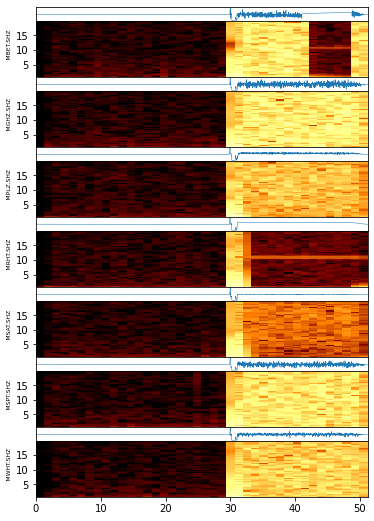

In [44]:
eventdir = 'MVO/WAV/MVOE_/2005/03'
dbLims=[-200,-100]
eventdir = 'MVO/WAV/ASNE_/1995/07'
dbLims=[-40,60]
pngdir = eventdir.replace('WAV', 'PNG')

if not os.path.exists(pngdir):
    os.makedirs(pngdir)
for root, dirs, files in os.walk(eventdir, topdown=False):
    files = sorted(files)
    #files = files[40:43]
    for name in files:
        if name[-4:]=='.png':
            continue
        thisfullpath = os.path.join(root, name)
        pngfile = thisfullpath.replace('WAV', 'PNG') + '.png'
        scaledfile = pngfile.replace('.png', '_Z_scaled.png')
        mseedfile = pngfile.replace('.png', '.mseed')
        sgramfile = pngfile.replace('.png', '_sgram.png')
        aeffile = pngfile.replace('.png', '.aef')
        picklefile = pngfile.replace('.png', '.pickle')

        print(thisfullpath, end = " ")
        if os.path.exists(mseedfile):
            st = read(mseedfile)
        else:
            try:
                st = read(thisfullpath)
            except:
                print('could not load')
            else:
                print(", read", end=" ")
                st.detrend()
                print(", detrended", end=" ")
                st.taper(max_percentage=0.05)
                print(", tapered. Looping over traces:")
                
                for tr in st:
                    tr.stats.network = 'MN'
                    tr.stats.channel += tr.stats.location
                    tr.stats.location = ''
                    respfile = "MVO/CAL/RESP.%s" % tr.id
                    print("- ", tr.id, respfile, end=" ")
                
                    if os.path.exists(respfile):
                        print(', exists', end=" ")
                        this_inv = _read_resp(respfile)
                        print(', loaded', end=" ")
                        pre_filt = [0.5, 0.8, 30, 50]
                        tr.remove_response(inventory=this_inv, pre_filt=pre_filt, output="VEL", water_level=60, plot=False)
                        print(', corrected')
                    else:
                        print(', not found')
                st.write(mseedfile)
                
        if len(st)==0:
            continue

        st.plot(equal_scale=False, outfile=pngfile, dpi=100);
        
        stZ = st.select(component='Z')
        if len(stZ)>0:  
            stZ.plot(equal_scale=True, outfile=scaledfile, dpi=100);
            plotMultiTraceSpectrogram(stZ, sgramfile, dbLims=dbLims)
        ampengfft(st)
        
        # write pickle file
        st.write(picklefile, format='PICKLE')
        
        # write an AEF-file
        fptr = open(aeffile, 'w')
        fptr.write('NSLC, amp, eng, f0-1, f1-2, f2-3, f3-4, f4-5, f5-6, f6-7, f7-8, f8-9, f9-10, f10-11, f11-12, f12-13, f13-14, f14-15, f15-16\n')
        for tr in st:
            fptr.write('%s, %4.2e, %4.2e' % (tr.id, tr.stats.peakamp, tr.stats.energy))
            if 'ssam' in tr.stats:
                for x in tr.stats.ssam:
                    fptr.write(', %4.2e' % (x/tr.stats.peakamp))
            fptr.write('\n')
        fptr.close()
                
de                

In [76]:
def reconstituteTrace(tr, taperFraction=0.05, filterType="bandpass", freq=[0.1, 20.0], corners=2, zerophase=True, inv=None):

    # save the start and end times for later 
    startTime = tr.stats.starttime
    endTime = tr.stats.endtime
        
    # pad the Trace
    y = tr.data
    npts = tr.stats.npts
    npts_pad = int(taperFraction * npts_pad)
    y_prepend = fliplr(y[0:npts_pad])
    y_postpend = fliplr(y[-npts_pad:])
    y = np.concatenate(y_prepend, y, y_postpend)
    padStartTime = startTime - len(y_prepend)*tr.stats.delta
    tr.data = y
    tr.stats.startime = padStartTime
        
    # clean
    tr.detrend()
    tr.taper(max_percentage=taperfraction)
    tr.filter(filtertype, freq=freq, corners=corners, zerophase=zerophase)
        
    # deconvolve
    if inv:
        if tr.stats.channel[1]=='H': # a seismic velocity channel
            tr.remove_response(inventory=inv, output="VEL")    

    # remove the pad
    tr.trim(starttime=startTime, endtime=endTime)

['1995-09-01-0004-37S.ASNE__003', '1995-09-01-0004-37S.ASNE__003.png', '1995-09-01-0004-47S.ASNE__010', '1995-09-01-0004-47S.ASNE__010.png', '1995-09-01-0009-38S.ASNE__003', '1995-09-01-0009-38S.ASNE__003.png', '1995-09-01-0014-40S.ASNE__003', '1995-09-01-0014-40S.ASNE__003.png', '1995-09-01-0019-41S.ASNE__003', '1995-09-01-0019-41S.ASNE__003.png', '1995-09-01-0024-43S.ASNE__003', '1995-09-01-0024-43S.ASNE__003.png', '1995-09-01-0029-45S.ASNE__003', '1995-09-01-0029-45S.ASNE__003.png', '1995-09-01-0034-46S.ASNE__003', '1995-09-01-0034-46S.ASNE__003.png', '1995-09-01-0039-48S.ASNE__003', '1995-09-01-0039-48S.ASNE__003.png']
MVO/WAV/ASNE_/1995/09/1995-09-01-0004-37S.ASNE__003 seconds per FFT = 4.0
0.0 302.07 2.56 299.48
MVO/WAV/ASNE_/1995/09/1995-09-01-0004-47S.ASNE__010 seconds per FFT = 1.0
0.0 28.15 0.64 27.42
MVO/WAV/ASNE_/1995/09/1995-09-01-0009-38S.ASNE__003 seconds per FFT = 4.0
0.0 302.07 2.56 299.48
MVO/WAV/ASNE_/1995/09/1995-09-01-0014-40S.ASNE__003 seconds per FFT = 4.0
0.0 30

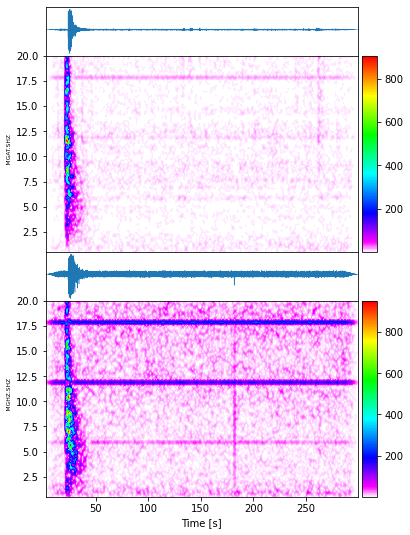

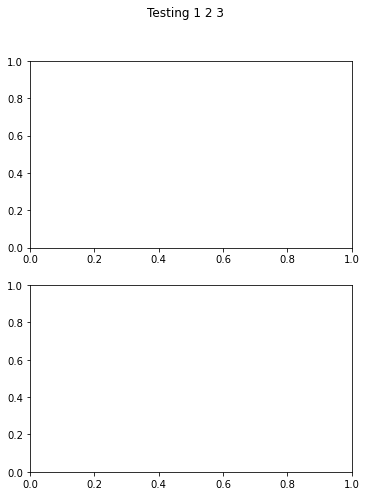

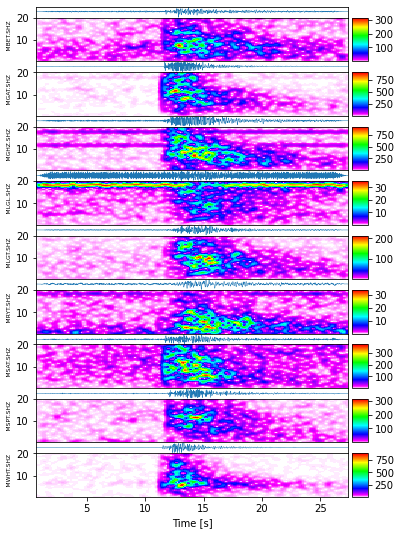

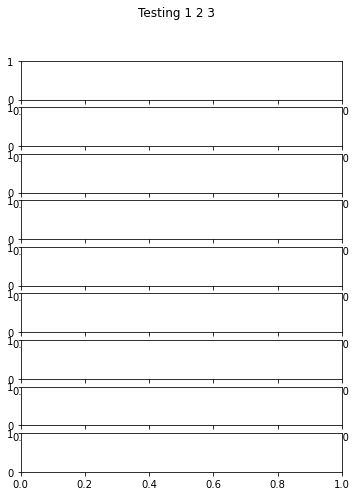

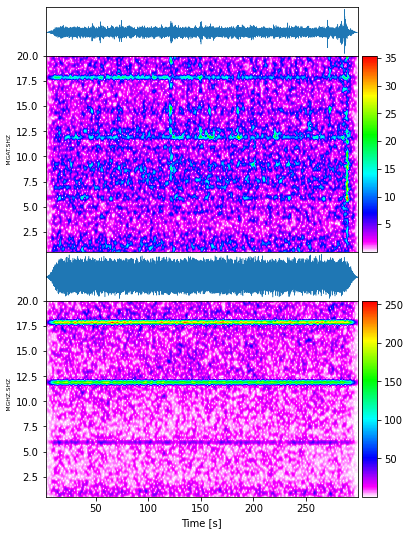

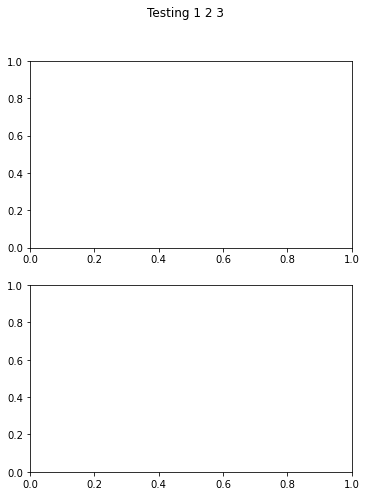

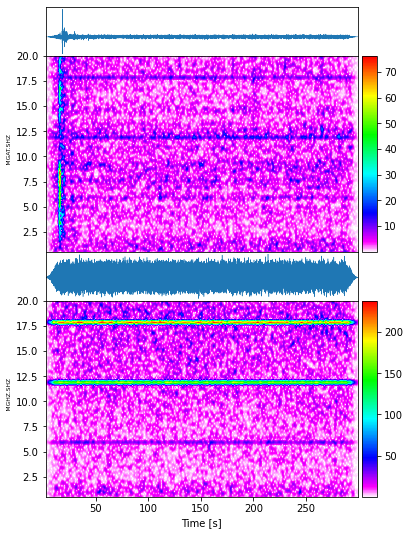

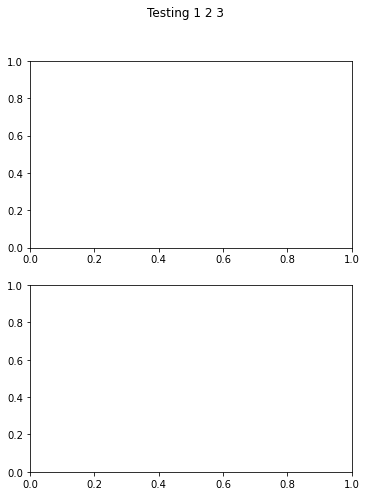

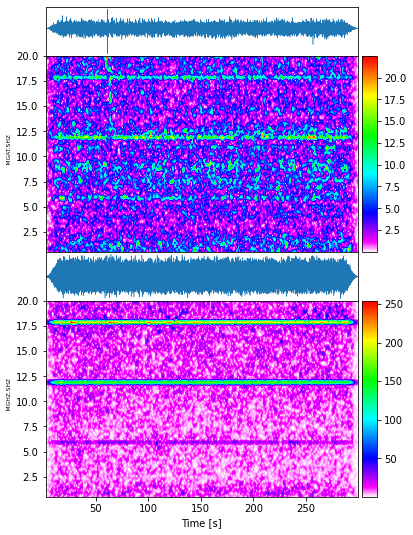

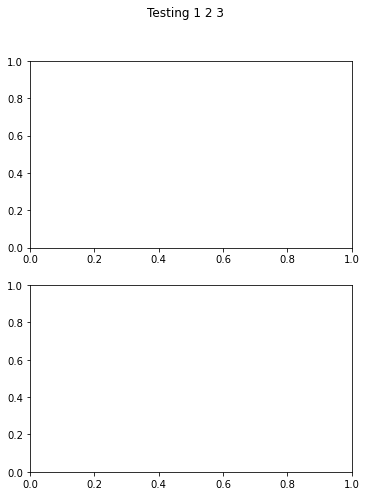

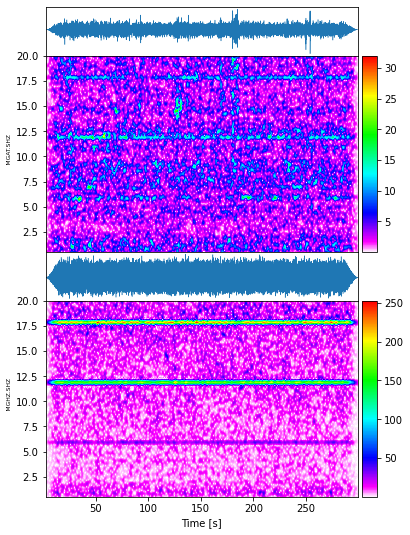

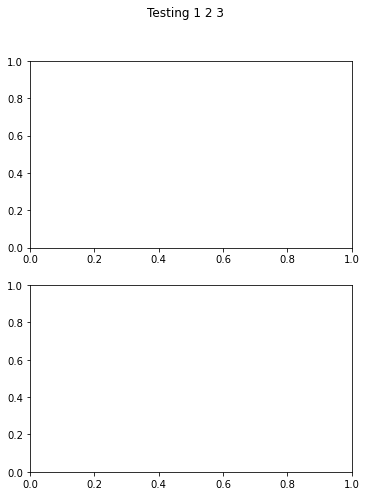

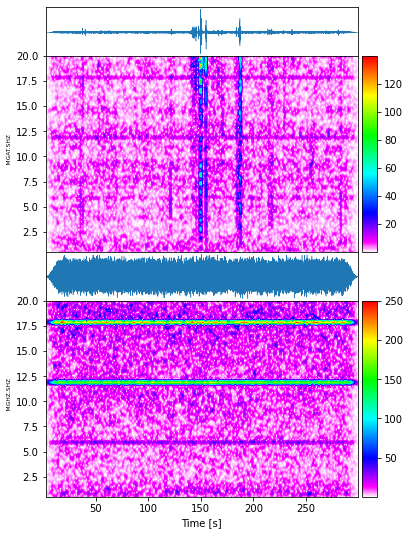

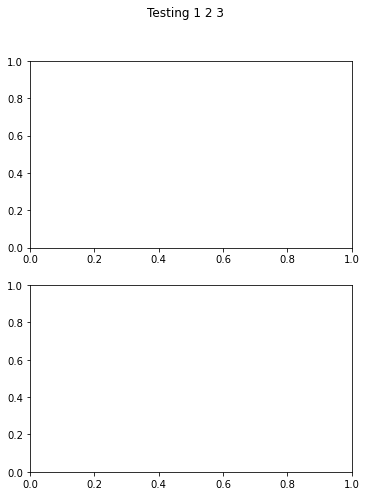

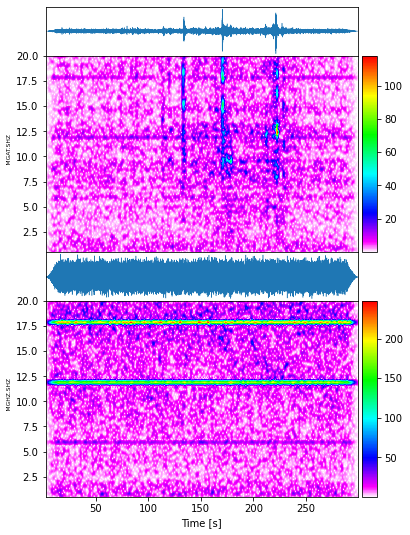

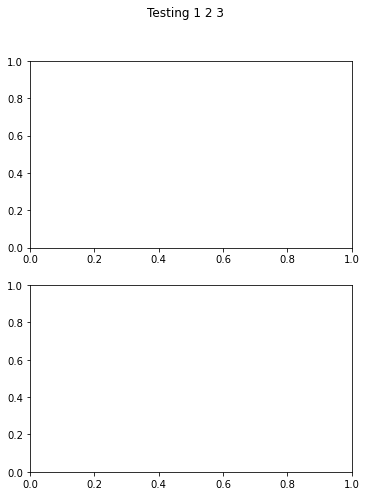

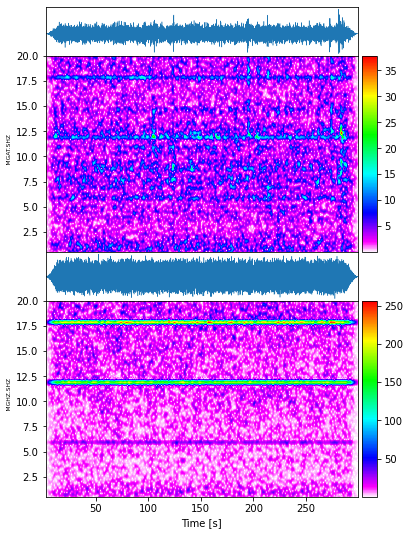

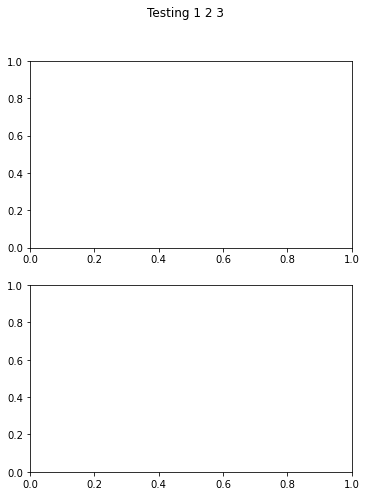

In [73]:
#eventdir = 'MVO/WAV/MVOE_/2005/03'
#dbLims=[-200,-100]
eventdir = 'MVO/WAV/ASNE_/1995/09'
#dbLims=[-40,60]
newdir = 'PNG2'
pngdir = eventdir.replace('WAV', newdir)

if not os.path.exists(pngdir):
    os.makedirs(pngdir)
for root, dirs, files in os.walk(eventdir, topdown=False):
    files = sorted(files)
    files = files[0:18]
    print(files)
    for name in files:
        if name[-4:]=='.png':
            continue
        thisfullpath = os.path.join(root, name)
        pngfile = thisfullpath.replace('WAV', newdir) + '.png'
        scaledfile = pngfile.replace('.png', '_Z_scaled.png')
        mseedfile = pngfile.replace('.png', '.mseed')
        sgramfile = pngfile.replace('.png', '_sgram.png')
        aeffile = pngfile.replace('.png', '.aef')
        picklefile = pngfile.replace('.png', '.pickle')

        print(thisfullpath, end = " ")
        st = Stream()
        if os.path.exists(mseedfile):
            st = read(mseedfile)
        else:
            try:
                st = read(thisfullpath)
            except:
                print('could not load')
            else:
                print(", read", end=" ")
                st.detrend()
                print(", detrended", end=" ")
                st.taper(max_percentage=0.05)
                print(", tapered. Looping over traces:")
                st.filter("highpass", freq=0.5)
                
                for tr in st:
                    tr.stats.network = 'MN'
                    tr.stats.channel += tr.stats.location
                    tr.stats.location = ''
                    respfile = "MVO/CAL/RESP.%s" % tr.id
                    print("- ", tr.id, respfile, end=" ")
                
                    if os.path.exists(respfile):
                        print(', exists', end=" ")
                        this_inv = _read_resp(respfile)
                        print(', loaded', end=" ")
                        #pre_filt = [0.5, 0.8, 30, 50]
                        #tr.remove_response(inventory=this_inv, pre_filt=pre_filt, output="VEL", water_level=60, plot=False)
                        tr.remove_response(inventory=this_inv, output="VEL")
                        print(', corrected')
                    else:
                        print(', not found')
                st.write(mseedfile)
                
        if len(st)==0:
            continue

        st.plot(equal_scale=False, outfile=pngfile, dpi=100);
        
        stZ = st.select(component='Z')
        if len(stZ)>0:  
            stZ.plot(equal_scale=True, outfile=scaledfile, dpi=100);
            icewebSpectrogram(stZ, outfile=sgramfile, log=False, equal_scale=False, add_colorbar=True, title="Testing 1 2 3")
        #ampengfft(st)
        continue
        
        # write pickle file
        st.write(picklefile, format='PICKLE')
        
        # write an AEF-file
        fptr = open(aeffile, 'w')
        fptr.write('NSLC, amp, eng, f0-1, f1-2, f2-3, f3-4, f4-5, f5-6, f6-7, f7-8, f8-9, f9-10, f10-11, f11-12, f12-13, f13-14, f14-15, f15-16\n')
        for tr in st:
            fptr.write('%s, %4.2e, %4.2e' % (tr.id, tr.stats.peakamp, tr.stats.energy))
            if 'ssam' in tr.stats:
                for x in tr.stats.ssam:
                    fptr.write(', %4.2e' % (x/tr.stats.peakamp))
            fptr.write('\n')
        fptr.close()

In [ ]:
# Attempts to load various instrument response files
#from obspy.io.xseed import Parser
#sp = Parser("MVO/CAL/MBGH_BH_Z.2005-08-17-0000_SEI")
from obspy.io.xseed.core import _read_resp
#_read_resp("MVO/CAL/MBGH_BH_Z.2005-08-17-0000_SEI")
#from  obspy.io.gse2.paz import read_paz
#read_paz("MVO/CAL/MBGH_BH_Z.2005-08-17-0000_SEI")
from obspy.io.xseed import Parser
sp = Parser("MVO/CAL/RESP.MN.MBGH..BHZ")
sp2 = _read_resp("MVO/CAL/RESP.MN.MBGH..BHZ")

In [ ]:
print(f)

In [ ]:
print(f.size)

In [42]:
np.Inf

inf

In [75]:
#eventdir = 'MVO/WAV/MVOE_/2005/03'
#dbLims=[-200,-100]
eventdir = 'MVO/WAV/ASNE_/1995/09'
#dbLims=[-40,60]
newdir = 'PNG2'
pngdir = eventdir.replace('WAV', newdir)

if not os.path.exists(pngdir):
    os.makedirs(pngdir)
for root, dirs, files in os.walk(eventdir, topdown=False):
    files = sorted(files)
    files = files[0:8]
    print(files)
    for name in files:
        if name[-4:]=='.png':
            continue
        thisfullpath = os.path.join(root, name)
        pngfile = thisfullpath.replace('WAV', newdir) + '.png'
        scaledfile = pngfile.replace('.png', '_Z_scaled.png')
        mseedfile = pngfile.replace('.png', '.mseed')
        sgramfile = pngfile.replace('.png', '_sgram.png')
        aeffile = pngfile.replace('.png', '.aef')
        picklefile = pngfile.replace('.png', '.pickle')

        print(thisfullpath, end = '')
        st = Stream()
        if os.path.exists(mseedfile):
            st = read(mseedfile)
        else:
            try:
                st = read(thisfullpath)
            except:
                print(' - could not load')
            else:
                print(' - loaded')
                for tr in st:
                    tr.stats.network = 'MN'
                    tr.stats.channel += tr.stats.location
                    tr.stats.location = ''
                    respfile = "MVO/CAL/RESP.%s" % tr.id
                    print(" - ", tr.id, respfile, end=" ")
                
                    this_inv = None
                    if os.path.exists(respfile):
                        this_inv = _read_resp(respfile)
                    
                    reconstituteTrace(tr, inv=this_inv)
                    print(" - reconstituted")

                st.write(mseedfile)
                print('Written to ',mseedfile)
                
        if len(st)==0:
            continue

        st.plot(equal_scale=False, outfile=pngfile, dpi=100);
        
        stZ = st.select(component='Z')
        if len(stZ)>0:  
            stZ.plot(equal_scale=True, outfile=scaledfile, dpi=100);
            icewebSpectrogram(stZ, outfile=sgramfile, log=False, equal_scale=False, add_colorbar=True, title="Testing 1 2 3")
        #ampengfft(st)
        continue
        
        # write pickle file
        st.write(picklefile, format='PICKLE')
        
        # write an AEF-file
        fptr = open(aeffile, 'w')
        fptr.write('NSLC, amp, eng, f0-1, f1-2, f2-3, f3-4, f4-5, f5-6, f6-7, f7-8, f8-9, f9-10, f10-11, f11-12, f12-13, f13-14, f14-15, f15-16\n')
        for tr in st:
            fptr.write('%s, %4.2e, %4.2e' % (tr.id, tr.stats.peakamp, tr.stats.energy))
            if 'ssam' in tr.stats:
                for x in tr.stats.ssam:
                    fptr.write(', %4.2e' % (x/tr.stats.peakamp))
            fptr.write('\n')
        fptr.close()

['1995-09-01-0004-37S.ASNE__003', '1995-09-01-0004-37S.ASNE__003.png', '1995-09-01-0004-47S.ASNE__010', '1995-09-01-0004-47S.ASNE__010.png', '1995-09-01-0009-38S.ASNE__003', '1995-09-01-0009-38S.ASNE__003.png', '1995-09-01-0014-40S.ASNE__003', '1995-09-01-0014-40S.ASNE__003.png']
MVO/WAV/ASNE_/1995/09/1995-09-01-0004-37S.ASNE__003 - loaded
 -  MN.LONG..SHE-- MVO/CAL/RESP.MN.LONG..SHE-- 

NameError: name 'reconstituteTrace' is not defined